In [1]:
import torch
from IPython.display import display
from PIL import Image
from transformers import ColPaliForRetrieval, ColPaliProcessor
from peft import PeftModel


def get_torch_device(device: str = "auto") -> str:
    """
    Returns the device (string) to be used by PyTorch.

    `device` arg defaults to "auto" which will use:
    - "cuda:0" if available
    - else "mps" if available
    - else "cpu".
    """
    if device == "auto":
        if torch.cuda.is_available():
            device = "cuda:0"
        elif torch.backends.mps.is_available():  # for Apple Silicon
            device = "mps"
        else:
            device = "cpu"

    return device

def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_torch_device("auto")

print(f"Using device: {device}")


# 加载 tokenizer 和基座模型
base_model_path = "/home/linux/yyj/colpali/finetune/colpali-v1.2-hf"
base_model = ColPaliForRetrieval.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
)
# 加载微调后的 adapter（LoRA 权重）
adapter_path = "/home/linux/yyj/colpali/finetune/wiky_city_zh_t_0605"
model = PeftModel.from_pretrained(base_model, adapter_path)
processor = ColPaliProcessor.from_pretrained(adapter_path)


Using device: cuda:0


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


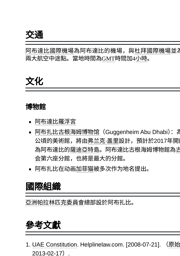

In [28]:
# Load the image and query inputs
image_filepath = "/home/linux/yyj/colpali/finetune/pdfTo_2x2_image_dense/Abu_Dhabi/page_002_q1.png"

image = [Image.open(image_filepath)]

queries = ["亞洲帕拉林匹克委員會總部"]

# Preview the input images
for image in image:
    display(scale_image(image, 256))

In [29]:
# Preprocess inputs
batch_images = processor(images=image).to(model.device)
batch_queries = processor(text=queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings
print(image_embeddings)
print(query_embeddings)

tensor([[[-0.0261, -0.0713,  0.0063,  ..., -0.0723, -0.0205, -0.0271],
         [-0.0064, -0.0471, -0.0483,  ..., -0.0245,  0.0225, -0.0649],
         [-0.1084,  0.0165,  0.0238,  ..., -0.1357, -0.0255, -0.0527],
         ...,
         [ 0.0081,  0.0430,  0.1582,  ...,  0.0142, -0.0280, -0.0060],
         [-0.0728,  0.1191,  0.0801,  ...,  0.0310, -0.0669, -0.1533],
         [-0.0325,  0.1436,  0.1177,  ...,  0.1123, -0.1182, -0.1533]]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[[ 0.1504, -0.0120,  0.1045,  ..., -0.0415, -0.0938, -0.0337],
         [-0.1167, -0.1533,  0.0060,  ..., -0.0383, -0.0918,  0.1172],
         [ 0.0071, -0.0530,  0.0645,  ..., -0.0262, -0.0713, -0.0762],
         ...,
         [-0.0469, -0.1084,  0.1206,  ..., -0.0260,  0.0564, -0.0723],
         [-0.0322, -0.1089,  0.1309,  ..., -0.0201,  0.0554, -0.0728],
         [-0.0508, -0.0786,  0.1211,  ..., -0.0197,  0.0444, -0.0767]]],
       device='cuda:0', dtype=torch.bfloat16)


In [30]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[10.1875]], dtype=torch.bfloat16)

In [31]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin


def get_n_patches(processor: ProcessorMixin, patch_size: int) -> Tuple[int, int]:
    n_patches_x = processor.image_processor.size["width"] // patch_size
    n_patches_y = processor.image_processor.size["height"] // patch_size
    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    return batch_images.input_ids == processor.image_token_id

In [32]:
image = image
query = queries[0]
processed_query = processor(text=[query]).to(model.device)

image_embedding = image_embeddings[[0], ...]
query_embedding = query_embeddings[[0], ...]

In [33]:
# Get the number of patches and the image mask
n_patches = get_n_patches(processor=processor, patch_size=model.vlm.vision_tower.config.patch_size)
image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Get the similarity maps for the first image in the batch
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embedding,
    query_embeddings=query_embedding,
    n_patches=n_patches,
    image_mask=image_mask,
)
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

# Use this cell output to choose a token using its index
query_content = processor.decode(processed_query.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁亞',
 4: '洲',
 5: '帕',
 6: '拉',
 7: '林',
 8: '匹',
 9: '克',
 10: '委員會',
 11: '總',
 12: '部'}


Selected token: `委員會`


/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22996 (\N{CJK UNIFIED IDEOGRAPH-59D4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21729 (\N{CJK UNIFIED IDEOGRAPH-54E1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26371 (\N{CJK UNIFIED IDEOGRAPH-6703}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


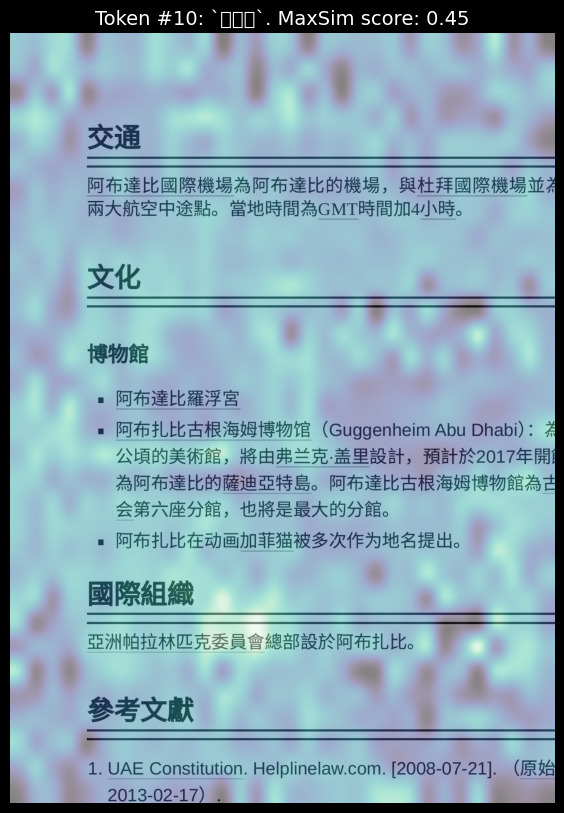

In [36]:
# Choose a token using its index
token_idx = 10  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

In [35]:
# plots = plot_all_similarity_maps(
#     image=image,
#     query_tokens=query_tokens,
#     similarity_maps=similarity_maps,
#     figsize=(8, 8),
#     show_colorbar=False,
#     add_title=True,
# )

# for idx, (fig, ax) in enumerate(plots):
#     savepath = f"similarity_map_{idx}.png"
#     fig.savefig(savepath, bbox_inches="tight")
#     print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

# plt.close("all")